<a href="https://colab.research.google.com/github/mustapha-lemjid/image/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
    ###et commencez par télécharger nos exemples de données, un .zip de 2 000 images JPG de chats et de chiens, et extrayez-les localement dans / tmp.

--2020-04-13 18:20:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  60.6MB/s    in 1.1s    

2020-04-13 18:20:43 (60.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
#Le contenu du fichier .zip est extrait dans le répertoire de base / tmp / cats_and_dogs_filtered,
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Repartoire avec nos photos de chats dresseurs
train_cats_dir = os.path.join(train_dir, 'cats')

# Repartoire avec nos photos de chiens dresseurs
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Repartoir avec nos photos de chat de validation
validation_cats_dir = os.path.join(validation_dir, 'cats')

# repartoir avec nos photos de chiens de validation
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
 

In [0]:

#Voyons maintenant à quoi ressemblent les noms de fichiers dans les répertoires de train des chats et des chiens (les conventions de dénomination des fichiers sont les mêmes dans le répertoire de validation):
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.134.jpg', 'cat.338.jpg', 'cat.821.jpg', 'cat.723.jpg', 'cat.439.jpg', 'cat.421.jpg', 'cat.372.jpg', 'cat.753.jpg', 'cat.362.jpg', 'cat.64.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [0]:
#Voyons le nombre total d'images de chats et de chiens dans les répertoires de train et de validation:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [0]:
#Pour les chats et les chiens, nous avons 1000 images d'entraînement et 500 images de test.
#Jetons maintenant un coup d'œil à quelques images pour mieux comprendre à quoi ressemblent les jeux de données sur les chats et les chiens. Tout d'abord, configurez les paramètres matplot:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paramètres pour notre graphique; nous sortirons des images dans une configuration 4x4
nrows = 4
ncols = 4

# Index pour itérer sur les images
pic_index = 0

In [0]:
#Maintenant, affichez un lot de 8 photos de chats et 8 photos de chiens. Vous pouvez réexécuter la cellule pour voir un nouveau lot à chaque fois:

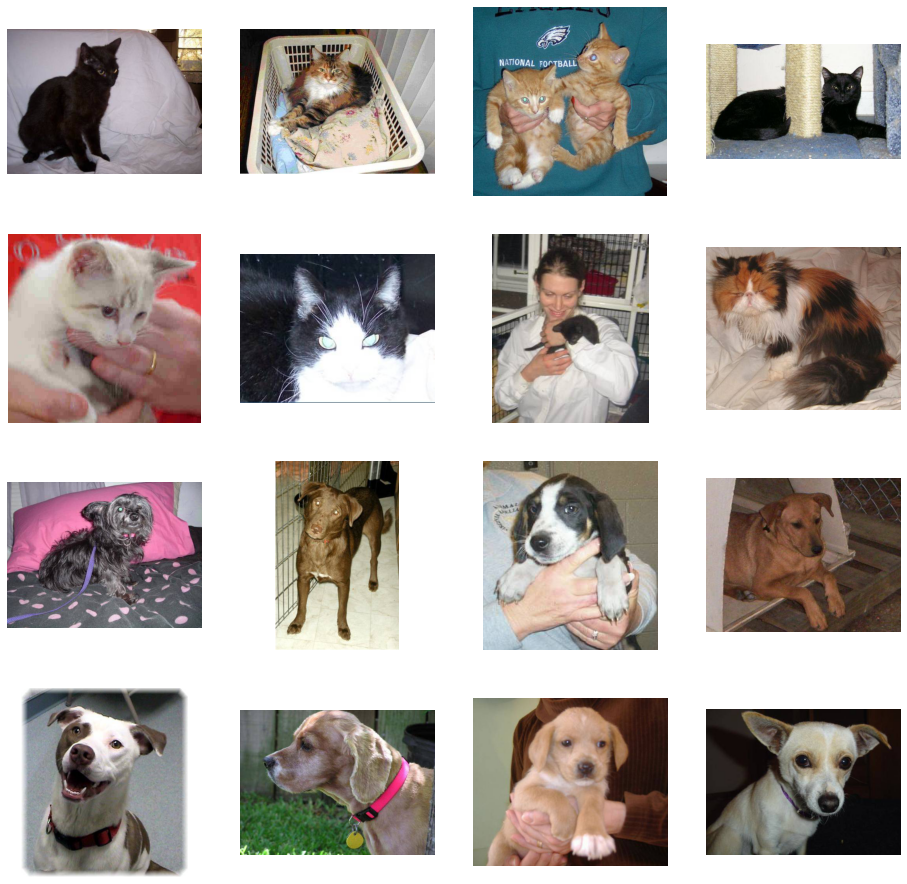

In [0]:
# Configurer la figue matplotlib et la dimensionner pour qu'elle s'adapte aux photos 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Configurer le sous-tracé; les indices de sous-parcelles commencent à 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Ne pas afficher les axes (ou les quadrillages)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [0]:
#Construire un petit convnet à partir de zéro pour atteindre une précision de 72%
#Les images qui iront dans notre convnet sont des images couleur 150x150 (dans la section suivante sur le prétraitement des données, nous ajouterons la gestion pour redimensionner toutes les images à 150x150 avant de les alimenter dans le réseau neuronal).

#Codons l'architecture. Nous empilerons 3 modules {convolution + relu + maxpool}. Nos convolutions opèrent sur des fenêtres 3x3 et nos couches maxpool fonctionnent sur des fenêtres 2x2. Notre première convolution extrait 16 filtres, la suivante extrait 32 filtres et la dernière extrait 64 filtres.

#REMARQUE: il s'agit d'une configuration largement utilisée et connue pour bien fonctionner pour la classification d'images. De plus, comme nous avons relativement peu d'exemples de formation (1 000), l'utilisation de seulement trois modules convolutionnels maintient le modèle petit, ce qui réduit le risque de sur-ajustement (que nous explorerons plus en détail dans l'exercice 2).

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Notre carte d'entités en entrée est 150x150x3: 150x150 pour les pixels de l'image et 3 pour
# les trois canaux de couleur: R, G et B
img_input = layers.Input(shape=(150, 150, 3))

# La première convolution extrait 16 filtres 3x3
# La convolution est suivie d'une couche de regroupement max avec une fenêtre 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# La deuxième convolution extrait 32 filtres 3x3
# La convolution est suivie d'une couche de regroupement max avec une fenêtre 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#La troisième convolution extrait 64 filtres 3x3
# La convolution est suivie d'une couche de regroupement max avec une fenêtre 2x2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [0]:
#En plus, nous collons deux couches entièrement connectées. Parce que nous sommes confrontés à un problème de classification à deux classes, c'est-à-dire un problème de classification binaire, nous terminerons notre réseau par une activation sigmoïde, de sorte que la sortie de notre réseau sera un seul scalaire entre 0 et 1, codant la probabilité que le courant l'image est de classe 1 (par opposition à la classe 0).

In [0]:
#Aplatir la carte d'entités à un tenseur 1-dim afin que nous puissions ajouter des canapés entièrement connectés
x = layers.Flatten()(x)

# Créez une couche entièrement connectée avec l'activation ReLU et 512 unités cachées
x = layers.Dense(512, activation='relu')(x)

# Créer une couche de sortie avec un seul nœud et une activation sigmoïde
output = layers.Dense(1, activation='sigmoid')(x)

# Créer un modèle:
# input = carte d'entités en entrée
# sortie = carte d'entités en entrée + couches de convolution / maxpool empilées + entièrement
# couche connectée + couche de sortie sigmoïde
model = Model(img_input, output)

In [0]:
#Résumons l'architecture du modèle:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Toutes les images seront redimensionnées d'ici le 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Débit d'images d'entraînement par lots de 20 à l'aide du générateur train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Ceci est le répertoire source des images d'entraînemen
        target_size=(150, 150),  # Toutes les images seront redimensionnées à 150x150
        batch_size=20,
        # Puisque nous utilisons la perte binary_crossentropy, nous avons besoin d'étiquettes binaires
        class_mode='binary')

#Images de validation de flux par lots de 20 à l'aide du générateur val_datagen
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * étapes
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * étapes
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 - 9s - loss: 0.8490 - acc: 0.5170 - val_loss: 0.6746 - val_acc: 0.6140
Epoch 2/15
100/100 - 9s - loss: 0.6638 - acc: 0.6345 - val_loss: 0.6108 - val_acc: 0.6690
Epoch 3/15
100/100 - 9s - loss: 0.5870 - acc: 0.7120 - val_loss: 0.5923 - val_acc: 0.7010
Epoch 4/15
100/100 - 9s - loss: 0.5063 - acc: 0.7565 - val_loss: 0.5496 - val_acc: 0.7300
Epoch 5/15
100/100 - 9s - loss: 0.4253 - acc: 0.8085 - val_loss: 0.5919 - val_acc: 0.7140
Epoch 6/15
100/100 - 9s - loss: 0.3172 - acc: 0.8590 - val_loss: 0.6505 - val_acc: 0.7340
Epoch 7/15
100/100 - 9s - loss: 0.2374 - acc: 0.8970 - val_loss: 0.8841 - val_acc: 0.7130
Epoch 8/15
100/100 - 9s - loss: 0.1620 - acc: 0.9355 - val_loss: 0.7989 - val_acc: 0.7450
Epoch 9/15
100/100 - 9s - loss: 0.1193 - acc: 0.9575 - val_loss: 1.0427 - val_acc: 0.7230
Epoch 10/15
100/100 - 9s - loss: 0.0930 - acc: 0.9655 - val_loss: 1.3165 - val_acc: 0.7450
Epoch 11/15
100/100 - 9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


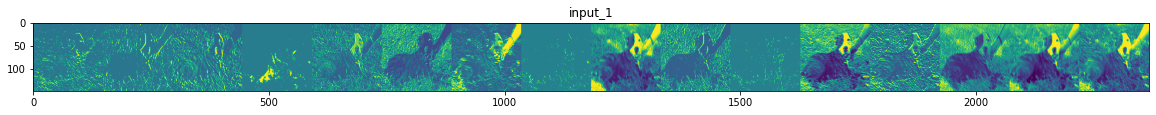

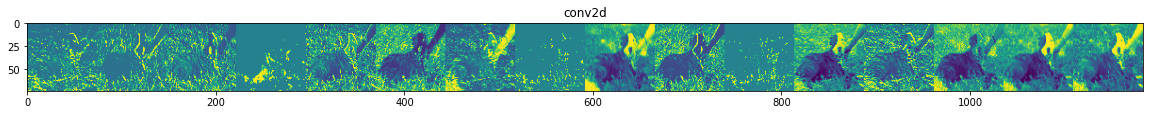

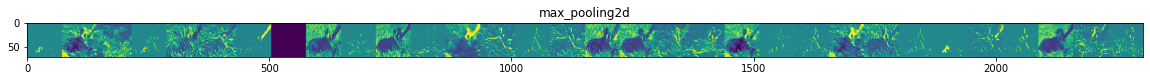

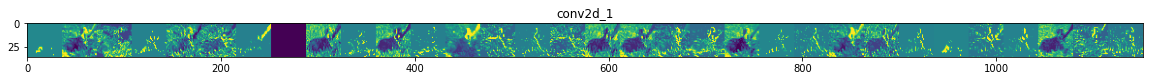

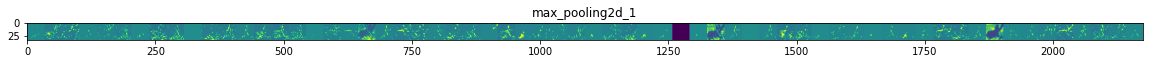

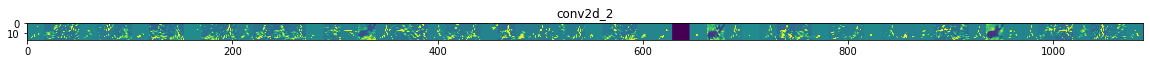

In [0]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Définissons un nouveau modèle qui prendra une image en entrée et sortira
# représentations intermédiaires pour toutes les couches du modèle précédent après
# la première.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

#Préparons une image d'entrée aléatoire d'un chat ou d'un chien à partir de l'ensemble de formation.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # c'est une image PIL
x = img_to_array(img)  # Tableau Numpy avec forme (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Redimensionner par 1/255
x /= 255

# Courons notre image à travers notre réseau, obtenant ainsi tous
# représentations intermédiaires pour cette image.
successive_feature_maps = visualization_model.predict(x)

# Ce sont les noms des couches, donc peuvent les avoir dans le cadre de notre intrigue
layer_names = [layer.name for layer in model.layers]

#Maintenant, affichons nos représentations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Faites-le simplement pour les couches conv / maxpool, pas pour les couches entièrement connectées
    n_features = feature_map.shape[-1]  # nombre d'entités dans la carte d'entités
    # La carte d'entités a une forme (1, taille, taille, n_features)
    size = feature_map.shape[1]
    # Nous allons carreler nos images dans cette matrice
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Post-traiter la fonctionnalité pour la rendre visuellement agréable au goût
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Nous allons carreler chaque filtre dans cette grande grille horizontale
      display_grid[:, i * size : (i + 1) * size] = x
    # Afficher la grille
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

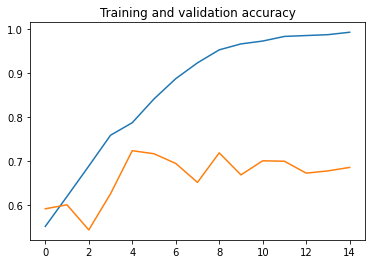

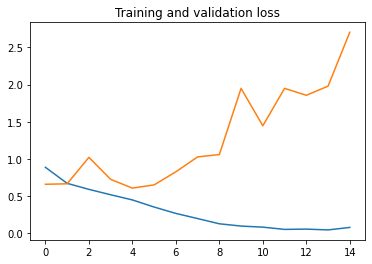

In [0]:
# Récupérer une liste de résultats d'exactitude sur les données de formation et de validation
# ensembles pour chaque période d'entraînement
acc = history.history['acc']
val_acc = history.history['val_acc']

# Récupérer une liste de résultats de liste sur les données de formation et de validation
# ensembles pour chaque période d'entraînement
loss = history.history['loss']
val_loss = history.history['val_loss']

# Obtenez le nombre d'époques
epochs = range(len(acc))

# Formation de tracé et précision de validation par époque
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Entraînement de tracé et perte de validation par époque
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)